In [2]:
import pandas as pd
from  decouple import Config,RepositoryEnv


#Set API Keys and File_path
config = Config(RepositoryEnv(".env"))
file_path = "./data/lg_all_features.csv"


# sklearn Model Trainer Class

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    accuracy_score,
    fbeta_score,
    roc_auc_score,
)
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay
import comet_ml
import logging
import matplotlib.pyplot as plt


class SklearnModelTrainer:
    def __init__(
        self, model_name, model,label, feature_columns, file_path, rs_state_modifier,logging=True,):
        self.model_name = model_name
        self.model = model
        self.label = label
        self.experiment = None
        self.file_path = file_path
        self.df = pd.read_csv(file_path)
        self.feature_columns = feature_columns
        self.logging = logging
        self.random_state = int(42 + rs_state_modifier)
        self.init_logging()

    def model_data_prep(self):
        for col_name in self.df.columns:
            try:
                self.feature_columns.index(col_name)
            except ValueError:
                logging.warning(f"{col_name} feature is being dropped")
                self.df = self.df.drop([col_name], axis=1)

        self.df = self.df.fillna(0)
        return self

    def get_log_time(self):
        return datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    def init_logging(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        self.app = logging.getLogger("SPARKIFY")
        self.app.info("Logging initialized %s.", self.get_log_time())

    def iniate_comet(self):
        if self.logging == True:
            self.experiment = comet_ml.Experiment(
                api_key=config("COMET_API"),
                project_name=config("PROJECT_NAME"),
                workspace=config("WORKSPACE"),
            )
        return self

    def normalize_dataframe(self,df,columns_to_normalize=None, scaler=None):

        # Get the list of numeric columns
        if columns_to_normalize is None:
            columns_to_normalize = df.select_dtypes(
                include=["float64", "int64"]
            ).columns.tolist()


        # If scaler is not provided, create a new MinMaxScaler
        if scaler is None:
            scaler = MinMaxScaler()
            df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
            normalized_data = df[columns_to_normalize]

            return normalized_data, scaler
        else:
            # Use the provided scaler to transform the data
            df[columns_to_normalize] = scaler.transform(df[columns_to_normalize])
            
        normalized_data = df[columns_to_normalize]


        return normalized_data

    def plot_conf_matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        # Create a new figure for each plot
        fig, ax = plt.subplots()
        disp.plot(ax=ax)

        # Set the title for the entire figure
        fig.suptitle(f"Confusion Matrix - {self.model_name}", fontsize=16)

        # Show the figure
        plt.show()

    def score_metrics(self, y_pred, y_test):
        def specificity_score(y_test, y_pred):
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            return tn / (tn + fp)

        specificity = specificity_score(y_test, y_pred)
        f1 = f1_score(y_pred=y_pred, y_true=y_test)
        precision = precision_score(y_pred=y_pred, y_true=y_test)
        recall = recall_score(y_pred=y_pred, y_true=y_test)
        accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
        f2 = fbeta_score(y_pred=y_pred, y_true=y_test, beta=2)
        auc = roc_auc_score(y_score=y_pred, y_true=y_test)

        metrics = {
            "AUC": auc,
            "f1": f1,
            "recall": recall,
            "precision": precision,
            "accuracy": accuracy,
            "f2": f2,
            "specificity": specificity,
        }

        return metrics

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.df.drop("label", axis=1),
            self.df["label"],
            train_size=0.8,
            random_state=42,
        )
        return X_train, X_test, y_train, y_test

    def build_params(self):
        params = {
            "model_name": self.model_name,
            "model": self.model,
            "model_params": self.model.get_params(),
            "features": self.df.columns,
            "data_source": self.file_path, 
             "split_random_state": self.random_state # Use self.file_path
        }
        return params

    def comet_logger(self, metrics, y_test, y_pred):
        self.experiment.log_metrics(metrics)
        self.experiment.log_parameters(self.build_params())

        self.experiment.log_confusion_matrix(
            y_true=y_test.tolist(),
            y_predicted=y_pred.tolist(),
            step=0,
            title="Confusion Matrix",
            file_name="confusion-matrix-%03d.json" % 0,
        )

    def train_and_predict(self):
        self.model_data_prep()
        X_train, X_test, y_train, y_test = self.split_data()
        scaled_X_train, scaler = self.normalize_dataframe(X_train)
        scaled_X_test  = self.normalize_dataframe(X_test, scaler=scaler)

        self.model.fit(scaled_X_train, y_train)
        y_pred = self.model.predict(scaled_X_test)

        return y_pred, y_test, self.model

    def evaluate_and_log_metrics(self, y_pred, y_test):
        self.metrics = self.score_metrics(y_pred=y_pred, y_test=y_test)
        self.plot_conf_matrix(y_pred=y_pred, y_test=y_test)
        if self.logging == True:
            self.comet_logger(metrics=self.metrics, y_test=y_test, y_pred=y_pred)

            self.experiment.end()
        return self.metrics

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

trainer_plan = {
    "model":{
    "LogisticRegression": LogisticRegression(
        class_weight="balanced", solver="saga", random_state=42,penalty="elasticnet",l1_ratio = 0.7,C=1.0
    ),
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=300, max_depth=25, min_samples_split=2, random_state=42
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    "SupportVectorClassifier": SVC(C=.7, kernel="rbf", gamma="scale", random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5, weights="uniform", algorithm="auto"),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
    ),
    "BaggingClassifier": BaggingClassifier(
        base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42
    ),
    "Gaussian_Naive_Bayes": GaussianNB(),
},
"feature_columns":['label', 'count', 'avg_daily_listens',
       'level_flag', 'pos_interactions', 'neg_interactions', 'distinct_artist',
       'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help',
       'Home', 'Login', 'Logout', 'Register', 'Roll Advert', 'Save Settings',
       'Settings', 'Submit Downgrade', 'Submit Registration', 'Submit Upgrade',
       'Thumbs Down', 'Thumbs Up', 'Upgrade', 'device_iOS', 'device_Linux',
       'device_Other', 'device_Ubuntu', 'device_Mac OS X', 'device_Windows',
       'browser_Firefox', 'browser_Safari', 'browser_Other',
       'browser_Chromium', 'browser_Google', 'browser_Mobile Safari',
       'browser_IE', 'browser_Chrome','time_since_registration']
}


2024-01-21 17:14:49,976 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:14:49.
2024-01-21 17:14:49,976 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:14:49,978 - root - WARNING - userId feature is being dropped


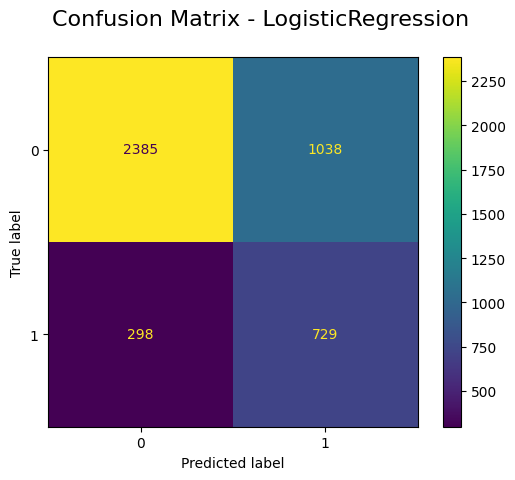

2024-01-21 17:14:50,438 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:14:50.
2024-01-21 17:14:50,440 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:14:50,446 - root - WARNING - userId feature is being dropped


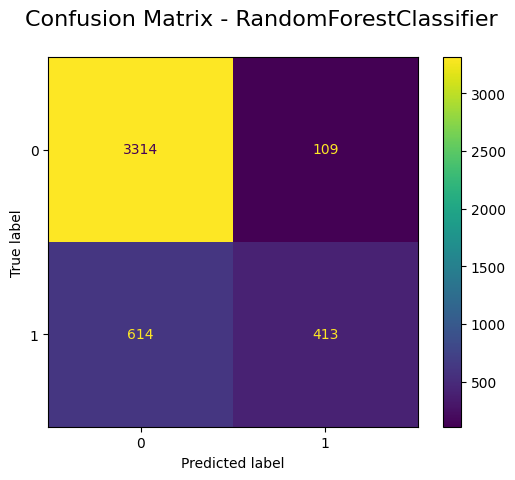

2024-01-21 17:14:57,097 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:14:57.
2024-01-21 17:14:57,098 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:14:57,101 - root - WARNING - userId feature is being dropped


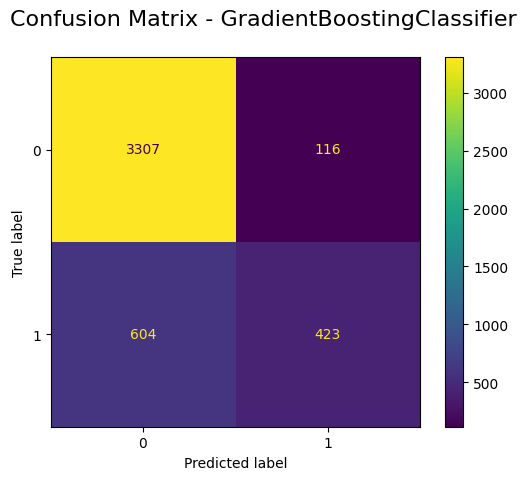

2024-01-21 17:15:00,657 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:15:00.
2024-01-21 17:15:00,658 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:15:00,660 - root - WARNING - userId feature is being dropped
/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


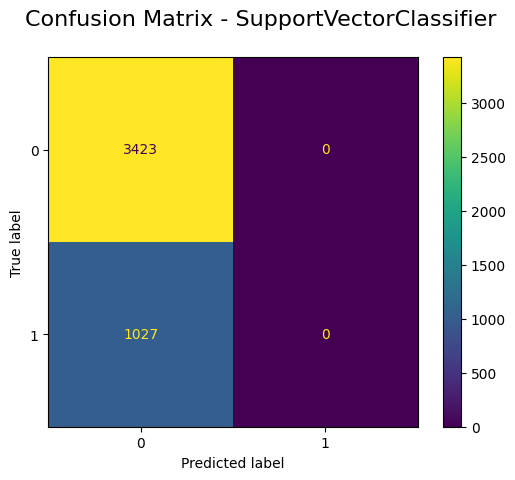

2024-01-21 17:15:06,418 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:15:06.
2024-01-21 17:15:06,418 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:15:06,420 - root - WARNING - userId feature is being dropped


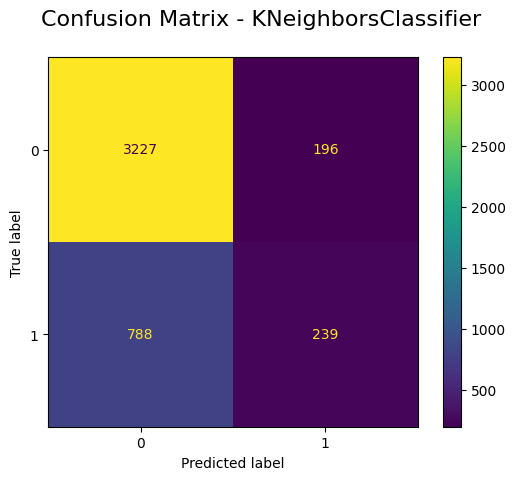

2024-01-21 17:15:06,656 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:15:06.
2024-01-21 17:15:06,657 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:15:06,658 - root - WARNING - userId feature is being dropped


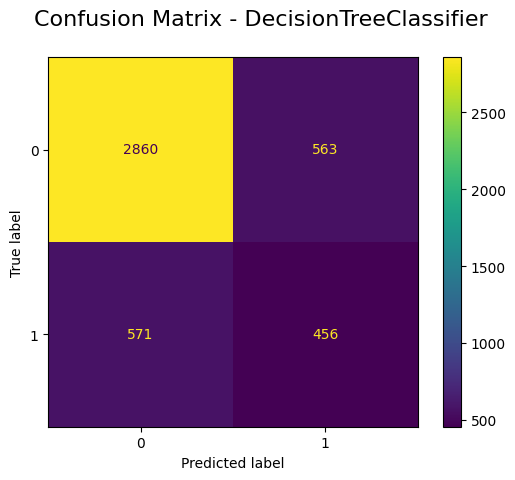

2024-01-21 17:15:06,974 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:15:06.
2024-01-21 17:15:06,974 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:15:06,977 - root - WARNING - userId feature is being dropped
/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


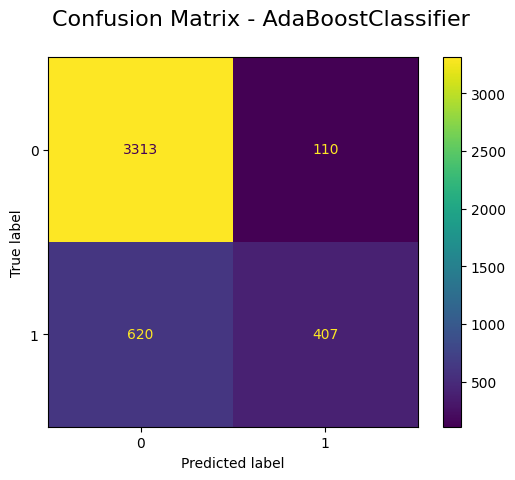

2024-01-21 17:15:10,857 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:15:10.
2024-01-21 17:15:10,858 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:15:10,859 - root - WARNING - userId feature is being dropped
/Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


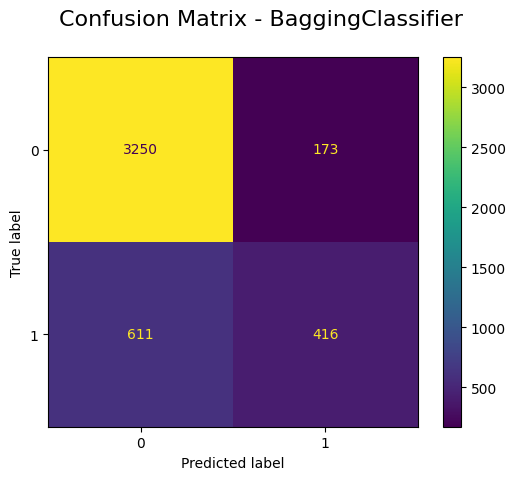

2024-01-21 17:15:12,253 - SPARKIFY - INFO - Logging initialized 2024-01-21 17:15:12.
2024-01-21 17:15:12,253 - root - WARNING - Unnamed: 0 feature is being dropped
2024-01-21 17:15:12,255 - root - WARNING - userId feature is being dropped


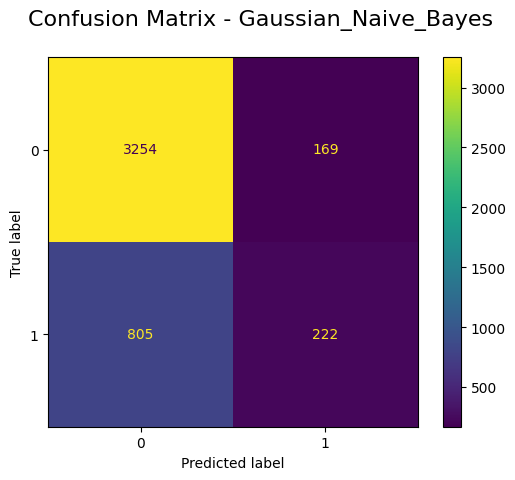

In [68]:
def model_run(model_name, model,label,feature_columns,file_path, logging,rs_state_mod):
    model_trainer = SklearnModelTrainer(model_name, model,label, feature_columns, file_path, logging, rs_state_mod)

    model_trainer.iniate_comet()
    y_pred, y_test, trained_model = model_trainer.train_and_predict()
    metrics = model_trainer.evaluate_and_log_metrics(y_pred, y_test)
    return metrics,model_trainer


# Build Dict for Quick Preforance Review
performance = {}
# Iterate through Model in Model plan
for rs_state_mod  in range(1):
    for model_name in trainer_plan["model"]:
        metrics,model_trainer = model_run(
            model_name=model_name,
            model=trainer_plan["model"][model_name],
            label = "label",
            feature_columns=trainer_plan["feature_columns"],
            file_path=file_path,
            logging=True,
            rs_state_mod= rs_state_mod
        )
        performance[model_name] = metrics

In [69]:
  
df = pd.DataFrame.from_dict(performance, orient='index')
df.sort_values(["AUC"], ascending=False)


,AUC,f1,recall,precision,accuracy,f2,specificity
LogisticRegression,0.703296,0.521832,0.709834,0.412564,0.699775,0.620426,0.696757
GradientBoostingClassifier,0.688995,0.540230,0.411879,0.784787,0.838202,0.455132,0.966112
RandomForestClassifier,0.685149,0.533247,0.402142,0.791188,0.837528,0.446004,0.968157
AdaBoostClassifier,0.682082,0.527202,0.396300,0.787234,0.835955,0.440000,0.967864
BaggingClassifier,0.677261,0.514851,0.405063,0.706282,0.823820,0.442836,0.949460
DecisionTreeClassifier,0.639768,0.445748,0.444012,0.447498,0.745169,0.444705,0.835524
KNeighborsClassifier,0.587728,0.326949,0.232717,0.549425,0.778876,0.263042,0.942740
Gaussian_Naive_Bayes,0.583396,0.313117,0.216164,0.567775,0.781124,0.246721,0.950628
SupportVectorClassifier,0.500000,0.000000,0.000000,0.000000,0.769213,0.000000,1.000000


In [22]:
  
df = pd.DataFrame.from_dict(performance, orient='index')
df.sort_values(["AUC"], ascending=False)


,AUC,f1,recall,precision,accuracy,f2,specificity
LogisticRegression,0.691705,0.504569,0.752678,0.379480,0.658876,0.628967,0.630733
RandomForestClassifier,0.690893,0.537156,0.446933,0.673021,0.822247,0.479123,0.934852
GradientBoostingClassifier,0.679841,0.518834,0.415774,0.689822,0.822022,0.451661,0.943909
AdaBoostClassifier,0.679599,0.520000,0.405063,0.726003,0.827416,0.444349,0.954134
BaggingClassifier,0.664650,0.487236,0.427459,0.566452,0.792360,0.449519,0.901840
Gaussian_Naive_Bayes,0.629255,0.423894,0.359299,0.516807,0.774607,0.382621,0.899211
DecisionTreeClassifier,0.622529,0.425157,0.493671,0.373343,0.691910,0.463776,0.751388
KNeighborsClassifier,0.607640,0.376665,0.289192,0.540000,0.779101,0.318806,0.926088
SupportVectorClassifier,0.500000,0.000000,0.000000,0.000000,0.769213,0.000000,1.000000


## Feature Importance

In [52]:
import numpy as np
model_name = df.index[0]


metrics,model_trainer = model_run(
        model_name=model_name,
        model=trainer_plan["model"][model_name],
        feature_columns=trainer_plan["feature_columns"],
        file_path=file_path,
        logging=True,
    )



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]
COMET INFO: Experiment is live on comet.com https://www.comet.com/dataspelunker/sparkify/9d2d36982189457696e51d22febc0de1



KeyError: "['label'] not found in axis"

In [ ]:

coefficients = model_trainer.model.coef_[0]
features = model_trainer.feature_columns

print(len(coefficients))
print(len(features))
features.remove("label")

39
40


<Axes: ylabel='Feature'>

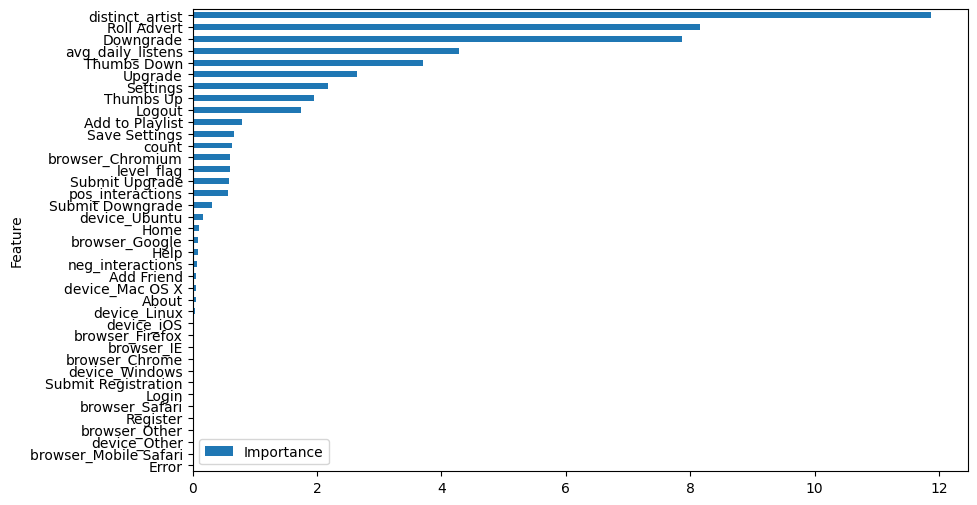

In [ ]:

feature_importance = pd.DataFrame({'Feature': features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

## H2O Linear Model

In [ ]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [ ]:
h2o.cluster().shutdown()

In [ ]:
from pyspark.sql import SparkSession
from pysparkling import *
import h2o



# Create Spark session
spark = SparkSession.builder.appName("YourAppName").getOrCreate()

h2o.init()
# Initialize H2OContext
hc = H2OContext.getOrCreate()

# Get H2OConf from H2OContext
h2o_conf = hc.getConf()

# Set H2OConf properties
h2o_conf.set("spark.ext.h2o.client.language", "python")


24/01/20 16:44:29 WARN Utils: Your hostname, Jacobs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.4.156 instead (on interface en0)
24/01/20 16:44:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/01/20 16:44:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/20 16:44:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21); OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from /Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/zp/9kxj13m57_v23k2hkwd8vz600000gn/T/tmpo81woxvx
  JVM stdout: /var/folders/zp/9kxj13m57_v23k2hkwd8vz600000gn/T/tmpo81woxvx/h2o_jacobfletcher_started_from_python.out
  JVM stderr: /var/folders/zp/9kxj13m57_v23k2hkwd8vz600000gn/T/tmpo81woxvx/h2o_jacobfletcher_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_jacobfletcher_jobrzu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


24/01/20 16:44:34 WARN InternalH2OBackend: Increasing 'spark.locality.wait' to value 0 (Infinitive) as we need to ensure we run on the nodes with H2O
24/01/20 16:44:34 WARN NativeLibrary: Cannot load library from path lib/osx_64/libxgboost4j_minimal.dylib
24/01/20 16:44:34 WARN NativeLibrary: Failed to load library from both native path and jar!
24/01/20 16:44:34 WARN XGBoostExtension: Cannot initialize XGBoost backend! Xgboost (enabled GPUs) needs: 
  - CUDA 8.0
XGboost (minimal version) needs: 
  - GCC 4.7+
For more details, run in debug mode: `java -Dlog4j.configuration=file:///tmp/log4j.properties -jar h2o.jar`



01-20 16:44:35.016 192.168.4.156:54321   61167    Thread-3  INFO water.default: ----- H2O started  -----
01-20 16:44:35.017 192.168.4.156:54321   61167    Thread-3  INFO water.default: Build git branch: rel-3.44.0
01-20 16:44:35.017 192.168.4.156:54321   61167    Thread-3  INFO water.default: Build git hash: 3f9977a3972e857f0ffb7b1925c75f972f9a07b1
01-20 16:44:35.017 192.168.4.156:54321   61167    Thread-3  INFO water.default: Build git describe: jenkins-3.44.0.2-25-g3f9977a
01-20 16:44:35.017 192.168.4.156:54321   61167    Thread-3  INFO water.default: Build project version: 3.44.0.3
01-20 16:44:35.017 192.168.4.156:54321   61167    Thread-3  INFO water.default: Build age: 1 month
01-20 16:44:35.017 192.168.4.156:54321   61167    Thread-3  INFO water.default: Built by: 'jenkins'
01-20 16:44:35.018 192.168.4.156:54321   61167    Thread-3  INFO water.default: Built on: '2023-12-20 16:31:48'
01-20 16:44:35.018 192.168.4.156:54321   61167    Thread-3  INFO water.default: Found H2O Core ex

H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month
H2O_cluster_name:,sparkling-water-jacobfletcher_local-1705787070588
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.44.0.3-1-3.5
 * H2O name: sparkling-water-jacobfletcher_local-1705787070588
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,192.168.4.156,54321)
  ------------------------

  Open H2O Flow in browser: http://192.168.4.156:54323 (CMD + click in Mac OSX)

    
Sparkling Water configuration:
  backend cluster mode : internal
  workers              : None
  cloudName            : sparkling-water-jacobfletcher_local-1705787070588
  base port            : 54321
  cloudTimeout         : 60000
  log level            : INFO
  nthreads             : -1
  drddMulFactor        : 10


In [ ]:
h2o_df = h2o.import_file(file_path)
# h2o_df = spark.read.option("header", True).csv(file_path)
h2o_df = h2o_df.drop("userId")

try:
    h2o_df.drop('C1')
    h2o_df.drop('userId')
except Exception as e:
    pass

col_features = h2o_df.columns
col_features.remove("label")
# Split the data into training and validation sets
# Split the data into training and validation sets
train, valid = h2o_df.split_frame(ratios=[0.85])

# Define predictor and response columns
predictor_cols = col_features
response_col = "label"




In [ ]:


# Define hyperparameter grid
hyperparams = {
    'alpha': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],  # Regularization parameter
    'lambda': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
}

# Initialize the linear regression model
linear_reg = H2OGeneralizedLinearEstimator(family='binomial', link="logit")

# Perform grid search
grid_search = H2OGridSearch(linear_reg, hyperparams)
grid_search.train(x=predictor_cols, y=response_col, training_frame=train)

# Get the best model from the grid search
best_model = grid_search.get_grid()[0]

# Make predictions on the validation set
preds = best_model.predict(valid)

# Get model performance on the validation set
validation_performance = best_model.model_performance(valid)


01-20 16:46:40.819 192.168.4.156:54321   61167  6762555-76  INFO water.default: POST /99/Grid/glm, parms: {fold_assignment=auto, calc_like=False, build_null_model=False, theta=1e-10, generate_scoring_history=False, compute_p_values=False, fix_dispersion_parameter=False, score_each_iteration=False, gradient_epsilon=-1.0, prior=-1.0, max_active_predictors=-1, remove_collinear_columns=False, hyper_parameters={"alpha": [0.0,0.2,0.4,0.6,0.8,1.0],"lambda": [1e-05,0.0001,0.001,0.01,0.1,1.0]}, solver=auto, max_iterations=-1, keep_cross_validation_predictions=False, tweedie_epsilon=8e-17, auc_type=auto, stopping_metric=auto, lambda_search=False, training_frame=py_11_sid_8036, stopping_tolerance=0.001, init_dispersion_parameter=1.0, score_iteration_interval=-1, tweedie_variance_power=0.0, intercept=True, max_confusion_matrix_size=20, dispersion_learning_rate=0.5, fix_tweedie_variance_power=True, non_negative=False, stopping_rounds=0, seed=-1, missing_values_handling=mean_imputation, dispersion_e

Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.


01-20 16:46:44.559 192.168.4.156:54321   61167  6762555-92  INFO water.default: GET /3/Models/Grid_GLM_py_11_sid_8036_model_python_1705787074211_2_model_3, parms: {}
01-20 16:46:44.569 192.168.4.156:54321   61167  6762555-76  INFO water.default: GET /3/Models/Grid_GLM_py_11_sid_8036_model_python_1705787074211_2_model_4, parms: {}
01-20 16:46:44.578 192.168.4.156:54321   61167  6762555-92  INFO water.default: GET /3/Models/Grid_GLM_py_11_sid_8036_model_python_1705787074211_2_model_5, parms: {}
01-20 16:46:44.588 192.168.4.156:54321   61167  6762555-76  INFO water.default: GET /3/Models/Grid_GLM_py_11_sid_8036_model_python_1705787074211_2_model_6, parms: {}
01-20 16:46:44.597 192.168.4.156:54321   61167  6762555-92  INFO water.default: GET /3/Models/Grid_GLM_py_11_sid_8036_model_python_1705787074211_2_model_7, parms: {}
01-20 16:46:44.607 192.168.4.156:54321   61167  6762555-76  INFO water.default: GET /3/Models/Grid_GLM_py_11_sid_8036_model_python_1705787074211_2_model_8, parms: {}
01-2

In [ ]:

print(validation_performance.F1())
print(validation_performance.F2())

[[0.21979435904992367, 0.4649681528662421]]
[[0.15152607925481082, 0.615286158347047]]


In [ ]:
validation_performance

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16301483403579897
RMSE: 0.4037509554611592
LogLoss: 0.5012043847066878
AUC: 0.693643387962006
AUCPR: 0.3996953473088845
Gini: 0.38728677592401195
Null degrees of freedom: 3384
Residual degrees of freedom: 3349
Null deviance: 3655.248396908102
Residual deviance: 3393.153684464277
AIC: 3465.153684464277

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21979435904992367
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1698  907   0.3482   (907.0/2605.0)
1      269   511   0.3449   (269.0/780.0)
Total  1967  1418  0.3474   (1176.0/3385.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.219794     0.464968  226
max f2                       0.151526     0.615286  292
max f0point5                 0.280588     0.423604  176
max accuracy                 0.54906      0.774298  46
max precision                0.959699     1         0
max recall                   0.00750791   1         396
max specificity              0.959699     1         0
max absolute_mcc             0.219794     0.261988  226
max min_per_class_accuracy   0.219794     0.651823  226
max mean_per_class_accuracy  0.219794     0.653476  226
max tns                      0.959699     2605      0
max fns                      0.959699     779       0
max fps                      0.00246109   2605      399
max tps                      0.00750791   780       396
max tnr                      0.959699     1         0
max fnr                      0.959699     0.998718  0
max fpr                      0.00246109   1         399
max tpr                      0.00750791   1         396

Gains/Lift Table: Avg response rate: 23.04 %, avg score: 22.24 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100443                   0.6562             2.68043   2.68043            0.617647         0.751245   0.617647                    0.751245            0.0269231       0.0269231                  168.043   168.043            0.0219327
2        0.0200886                   0.564694           2.42515   2.55279            0.558824         0.601786   0.588235                    0.676515            0.024359        0.0512821                  142.515   155.279            0.0405335
3        0.0301329                   0.513787           1.91459   2.34006            0.441176         0.537661   0.539216                    0.630231            0.0192308       0.0705128                  91.4593   134.006            0.0524706
4        0.0401773                   0.476505           1.91459   2.23369            0.441176         0.493591   0.514706                    0.596071            0.0192308       0.0897436                  91.4593   123.369            0.0644077
5        0.0502216                   0.451538           2.16987   2.22093            0.5              0.463035   0.511765                    0.569463            0.0217949       0.111538                   116.987   122.093            0.0796767
6        0.100148                    0.372145           1.84888   2.03545            0.426036         0.406638   0.469027                    0.488291            0.0923077       0.203846                   84.8885   103.545            0.134748
7        0.150074                    0.328536           1.72049   1.93067            0.39645          0.350136   0.444882                    0.44233

In [ ]:



h2o_df = h2o.import_file(file_path)
# h2o_df = spark.read.option("header", True).csv(file_path)
h2o_df = h2o_df.drop("userId")

try:
    h2o_df.drop('C1')
    h2o_df.drop('userId')
except Exception as e:
    pass

col_features = h2o_df.columns
col_features.remove("label")
# Split the data into training and validation sets
# Split the data into training and validation sets
train, valid = h2o_df.split_frame(ratios=[0.85])

# Define predictor and response columns
predictor_cols = col_features
response_col = "label"


# Define hyperparameter grid
hyperparams = {
    'learn_rate': [0.01, 0.1, 0.2],
    'ntrees': [50, 100, 200],
    'max_depth': [3, 4, 5],
}

gradient_boost = H2OGradientBoostingEstimator(seed=42)


# Perform grid search
grid_search = H2OGridSearch(gradient_boost, hyperparams)
grid_search.train(x=predictor_cols, y=response_col, training_frame=train)

# Get the best model from the grid search
best_model = grid_search.get_grid()[0]

# Make predictions on the validation set
preds = best_model.predict(valid)

# Get model performance on the validation set
validation_performance = best_model.model_performance(valid)



01-20 16:45:16.929 192.168.4.156:54321   61167  6762555-78  INFO water.default: POST /3/ImportFilesMulti, parms: {paths=[/Users/jacobfletcher/git/churn_project/data/lg_all_features.csv]}
01-20 16:45:16.932 192.168.4.156:54321   61167  6762555-92  INFO water.default: POST /3/ParseSetup, parms: {source_frames=["nfs://Users/jacobfletcher/git/churn_project/data/lg_all_features.csv"], single_quotes=False, check_header=0}
01-20 16:45:17.217 192.168.4.156:54321   61167  6762555-92  INFO water.default: ParseSetup heuristic: cloudSize: 1, cores: 12, numCols: 42, maxLineLength: 167, totalSize: 3236408, localParseSize: 3236408, chunkSize: 67426, numChunks: 47, numChunks * cols: 1974
01-20 16:45:17.223 192.168.4.156:54321   61167  6762555-78  INFO water.default: POST /3/Parse, parms: {chunk_size=67426, single_quotes=False, delete_on_done=True, parse_type=CSV, check_header=1, separator=44, escapechar=0, column_types=["Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","N

In [ ]:

validation_performance

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.15326187011957534
RMSE: 0.39148674322328636
MAE: 0.29938115856573133
RMSLE: 0.27569242700388985
Mean Residual Deviance: 0.15326187011957534

In [ ]:
MSE: 0.16301483403579897
RMSE: 0.4037509554611592
LogLoss: 0.5012043847066878
AUC: 0.693643387962006
AUCPR: 0.3996953473088845
Gini: 0.38728677592401195
Null degrees of freedom: 3384
Residual degrees of freedom: 3349
Null deviance: 3655.248396908102
Residual deviance: 3393.153684464277
AIC: 3465.153684464277